In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
from sklearn.model_selection import train_test_split, KFold
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix, plot_confusion_matrix
#from sklearn.model_selection import KFold
#from sklearn.metrics import confusion_matrix
from itertools import chain

In [2]:
# Function to set appropriate figure size for publication
# Width @516pts is for IEEE conference format
def set_size(width=516, fraction=1):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float
            Document textwidth or columnwidth in pts
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio

    fig_dim = (fig_width_in, fig_height_in)

    return fig_dim

In [3]:
# Data params
textures = 11
trials = 100

# Set bin and sim params
bin_size = 100   # Bin size in ms
sim_length = 5000   # Sim time in ms
bins = sim_length / bin_size

In [4]:
# Import dataset and labels from pickle
PATH = "/home/farscope2/Documents/PhD/Spiking Nets Project/SpikingNetsTexture/datasets/TacTip_NM/natural_classifier/"
DATA_NAME = str(sim_length) + "ms - " + str(bin_size) + "ms bin size dataset.pickle"
LABEL_NAME = str(textures) + " textures - " + str(trials) + " trials labels.pickle"

# Import dataset first
FILENAME = PATH + DATA_NAME

# Create array of intensities for heatmap
with(open(FILENAME, "rb")) as openfile:
    try:
        dataset = pickle.load(openfile)
    except EOFError:
        print(EOFError)
        
# Now import label array
FILENAME = PATH + LABEL_NAME

# Create array of intensities for heatmap
with(open(FILENAME, "rb")) as openfile:
    try:
        labels = pickle.load(openfile)
    except EOFError:
        print(EOFError)

In [5]:
# WARNING: Dataset created from previous script contains a NULL row 0
#          This row has currently been deleted and saved over the initial dataset
#          Note for next time is to fix this bug
#print(dataset[0])
#dataset = np.delete(dataset, 0, 0)
#print(len(dataset))
if len(dataset) == (trials * textures)+1:
    dataset = np.delete(dataset, 0, 0)
    
# Split data into testing and training
# Ration currently 80-20
x_train, x_test, y_train, y_test = train_test_split(dataset, labels, test_size=0.2)

In [6]:
# Create kfold validation model
folds = 10
kf = KFold(n_splits=folds, random_state=63, shuffle=True)

In [7]:
# Assess naive bayes over a range of data folds
# Lists to contain accuracy data
train_accuracies = []
train_recall = []
train_precision = []

val_accuracies = []
val_recall = []
val_precision = []

# Total confusion arrays
Y_true = []
Y_Pred = []

# Convert training data to np arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

# Create bayes classifier
bayes = GaussianNB()
    
# Loop through each of the folds within the kfold
for train_index, val_index in kf.split(x_train):
    # Create folded data
    Xtrain, Xval = x_train[train_index], x_train[val_index]
    ytrain, yval = y_train[train_index], y_train[val_index]
        
    # Fit the model to the new folded training data
    bayes.fit(Xtrain, ytrain)

    # Precit value using KNN
    #y_pred = knn.predict(x_test)
    pred_train = bayes.predict(Xtrain)
    pred_val = bayes.predict(Xval)
    
    # Append values to seperate array for confusion matrix
    Y_true.append(yval)
    Y_Pred.append(pred_val)

    #Calculate the accuracy of the predictions on the training set 
    #and save in the variable train_accuracies
    train_accuracies.append(accuracy_score(ytrain, pred_train))
    train_recall.append(recall_score(ytrain, pred_train, average='micro'))
    train_precision.append(precision_score(ytrain, pred_train, average='micro'))
        
    #Do the same for the predictions on the validation set
    val_accuracies.append(accuracy_score(yval, pred_val))
    val_recall.append(recall_score(yval, pred_val, average='micro'))
    val_precision.append(precision_score(yval, pred_val, average='micro'))

In [8]:
#Calculate the mean for training and validation accuracies
train_accuracy_mean = np.mean(train_accuracies)
val_accuracy_mean = np.mean(val_accuracies)

train_recall_mean = np.mean(train_recall)
val_recall_mean = np.mean(val_recall)

train_precision_mean = np.mean(train_precision)
val_precision_mean = np.mean(val_precision)

In [9]:
# Print mean values for accuracies
#print(train_accuracy_mean)
print(val_accuracy_mean)
print(np.max(val_accuracies))

# # Plot this data
# x = np.linspace(0, len(train_accuracies), len(train_accuracies))

# fig, ax = plt.subplots(figsize=(12,8))

# ax.plot(x, train_accuracies, color='r',label='Training Accuracy')
# ax.plot(x, val_accuracies, color='b',label='Validation Accuracy')
# plt.xlabel("Fold No.")
# plt.ylabel("Accuracy (%)")
# plt.title("Accuracy of Naive Bais for " + DATA_NAME)
# plt.savefig("/home/farscope2/Documents/PhD/Spiking Nets Project/SpikingNetsTexture/graphs/natural_classifier/" + DATA_NAME + " accuracy.png")
# ax.legend()
# plt.show()

0.6556818181818183
0.6931818181818182


In [10]:
# # Print mean values for recall
# print(train_recall_mean)
# print(val_recall_mean)

# # Plot this data
# fig, ax = plt.subplots(figsize=(12,8))

# ax.plot(x, train_recall, color='r',label='Training Recall')
# ax.plot(x, val_recall, color='b',label='Validation Recall')
# plt.xlabel("Fold No.")
# plt.ylabel("Recall")
# plt.title("Recall of Naive Bais for " + DATA_NAME)
# plt.savefig("/home/farscope2/Documents/PhD/Spiking Nets Project/SpikingNetsTexture/graphs/natural_classifier/" +
#                     DATA_NAME + " recall.png")
# ax.legend()
# plt.show()

In [11]:
# # Print mean values for precision
# print(train_precision_mean)
# print(val_precision_mean)

# # Plot this data
# fig, ax = plt.subplots(figsize=(12,8))

# ax.plot(x, train_precision, color='r',label='Training Precision')
# ax.plot(x, val_precision, color='b',label='Validation Precision')
# plt.xlabel("Fold No.")
# plt.ylabel("Precision")
# plt.title("Precision of Naive Bais for " + DATA_NAME)
# plt.savefig("/home/farscope2/Documents/PhD/Spiking Nets Project/SpikingNetsTexture/graphs/natural_classifier/" +
#                     DATA_NAME + " precision.png")
# ax.legend()
# plt.show()

In [12]:
SAVE_PATH = '/home/farscope2/Documents/PhD/Spiking Nets Project/SpikingNetsTexture/graphs/natural_classifier/'

In [13]:
Y_true = [item for sublist in Y_true for item in sublist]
#print(Y_true)
Y_Pred = [item for sublist in Y_Pred for item in sublist]

In [19]:
cnf_matrix = confusion_matrix(Y_true, Y_Pred)#, normalize='true')

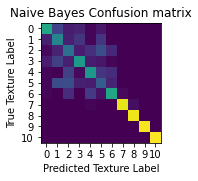

array([[47, 16,  6,  8,  1,  5,  0,  0,  0,  0,  0],
       [ 7, 36,  7, 12,  1, 12,  0,  0,  0,  0,  0],
       [ 2,  8, 29,  6, 11, 19,  9,  0,  0,  0,  0],
       [ 6, 15,  7, 43,  6,  5,  1,  0,  0,  0,  0],
       [ 1,  0, 15,  2, 42, 12, 10,  0,  0,  0,  0],
       [ 1, 18, 19,  7,  6, 23,  8,  0,  0,  0,  0],
       [ 1,  0, 10,  0, 13,  4, 47,  2,  0,  0,  0],
       [ 0,  0,  0,  0,  1,  0,  0, 76,  3,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 77,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 78,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 79]])

In [20]:
plt.figure(figsize=set_size(fraction=0.5))
plt.xticks(range(textures))
plt.yticks(range(textures))
plt.imshow(cnf_matrix)
plt.title('Naive Bayes Confusion matrix')
plt.xlabel("Predicted Texture Label")
plt.ylabel("True Texture Label")
plt.savefig(SAVE_PATH + DATA_NAME + " BAYES confusion.eps",bbox_inches="tight")
plt.show()
cnf_matrix

In [16]:
# norm = np.linalg.norm(cnf_matrix)
# normal_cnf = cnf_matrix/norm

In [17]:
# plt.figure(figsize=(6, 6))
# plt.xticks(range(11))
# plt.yticks(range(11))
# plt.imshow(normal_cnf)
# plt.title('Normalised Confusion matrix')
# plt.savefig(SAVE_PATH + DATA_NAME + " BAYES normalised confusion.png")
# plt.show()
# normal_cnf